In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DIR_PATH = '~/'

/Users/Drake/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## loading data as Pandas dataframes
train_raw = pd.read_csv(os.path.join(DIR_PATH, 'train.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test.csv'), 
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), 
                    header='infer')


In [5]:
train_final = pd.read_csv(os.path.join(DIR_PATH, 'train_final.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp.x'])

test_final = pd.read_csv(os.path.join(DIR_PATH, 'test_final.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp.x'])

In [ ]:
## start from property features first
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area', 
                     'price_doc']


train = train_raw[property_features]
test = test_raw[property_features[:-1]]

In [24]:
top_features = ['timestamp','full_sq', 'material', 'cafe_count_5000_price_high', 'state', 'num_room',
               'cafe_count_5000_price_2500', 'cafe_count_2000_price_2500','sport_count_3000', 'cafe_count_3000',
               'build_year', 'price_doc']

train = train_raw[top_features]
test = test_raw[top_features[:-1]]

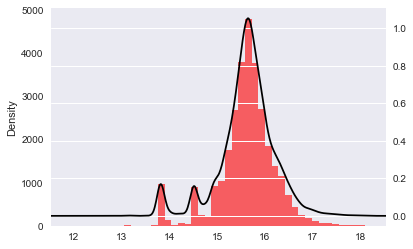

In [8]:
## distribution of log(price_doc+1)
vis.hist_density_plot(train, x='price_doc', logx=True)

In [9]:
print(train['material'].value_counts(dropna=False))
print(test['material'].value_counts(dropna=False))

 1.0    14197
NaN      9572
 2.0     2993
 5.0     1561
 4.0     1344
 6.0      803
 3.0        1
Name: material, dtype: int64
1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64


In [10]:
## set level 3 to np.nan
train.loc[train['material'] == 3, 'material'] = np.nan
test.loc[test['material'] == 3, 'material'] = np.nan

/Users/Drake/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


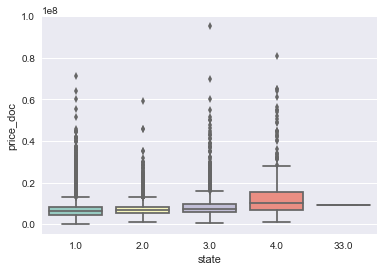

In [11]:
## state
sns.boxplot(x='state', 
            y='price_doc', 
            data=train, 
            palette='Set3')

In [12]:
print(train['state'].value_counts(dropna=False))
print(test['state'].value_counts(dropna=False))

NaN      13559
 2.0      5844
 3.0      5790
 1.0      4855
 4.0       422
 33.0        1
Name: state, dtype: int64
 2.0    2662
 1.0    2266
 3.0    1913
NaN      694
 4.0     127
Name: state, dtype: int64


In [13]:
train.loc[train['state'] == 33, 'state'] = 3

In [14]:
#Check build year:
train['build_year'].value_counts(dropna=False).sort_index()

 0.0             530
 1.0             368
 3.0               2
 20.0              1
 71.0              1
 215.0             1
 1691.0            1
 1860.0            2
 1876.0            1
 1886.0            1
 1890.0            5
 1895.0            1
 1896.0            2
 1900.0            2
 1904.0            1
 1905.0            1
 1906.0            1
 1907.0            2
 1910.0            5
 1911.0            1
 1912.0            5
 1914.0            3
 1915.0            5
 1917.0           16
 1920.0            1
 1924.0            3
 1925.0            1
 1926.0            8
 1927.0           10
 1928.0           12
               ...  
 1992.0          139
 1993.0          115
 1994.0          160
 1995.0          149
 1996.0          162
 1997.0          139
 1998.0          141
 1999.0          125
 2000.0          130
 2001.0          177
 2002.0          214
 2003.0          193
 2004.0          220
 2005.0          176
 2006.0          242
 2007.0          219
 2008.0      

In [15]:
## training build_year: 20052009 to 2009, 4965 to 1965, 71 to 1971, year < 1800 to np.nan
train.loc[train['build_year'] == 20052009, 'build_year'] = 2009
train.loc[train['build_year'] == 4965, 'build_year'] = 1965
train.loc[train['build_year'] == 71, 'build_year'] = 1971
train.loc[train['build_year'] < 1800, 'build_year'] = np.nan

In [16]:
## test build_year: year < 1800 to np.nan
test.loc[test['build_year'] < 1800, 'build_year'] = np.nan

In [18]:
## num_room
test.loc[test['num_room'] > 9, 'num_room'] = np.nan

In [19]:
## full_sq 
test.loc[test['full_sq'] > 400, 'full_sq'] = test.loc[test['full_sq'] > 400, 'full_sq'] / 10
test.loc[test['full_sq'] < 3, 'full_sq'] = np.nan

In [20]:
train.loc[13120, 'build_year'] = 1970

/Users/Drake/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


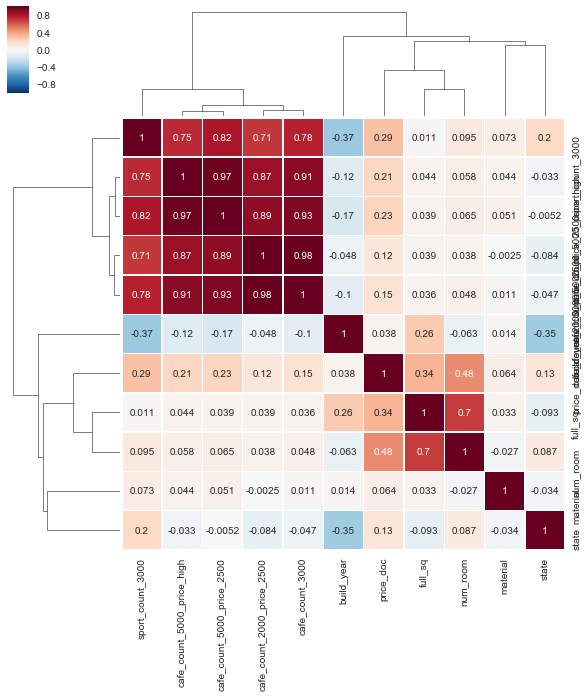

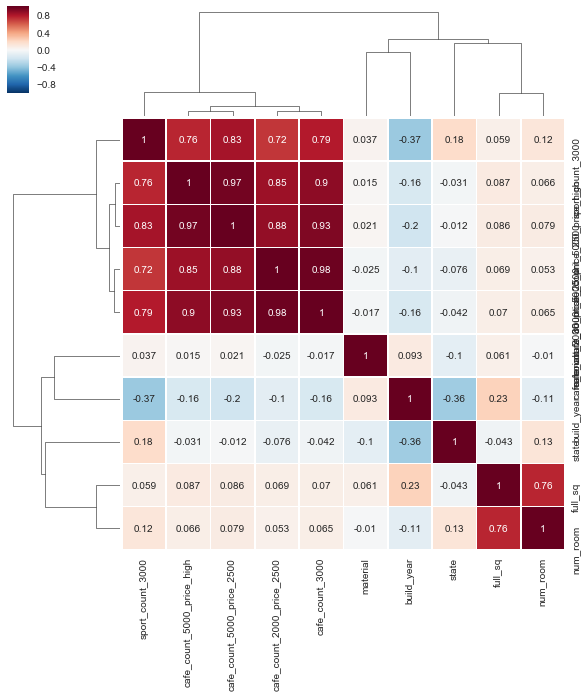

In [21]:
## correlation
vis.corr_plot(train)
vis.corr_plot(test)

In [28]:
#MODELING:
## log transformation
train.loc[:, 'log_price_doc'] = np.log(train['price_doc'] + 1)

In [25]:
# time features
train.loc[:, 'year'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
train.loc[:, 'month'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

test.loc[:, 'year'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
test.loc[:, 'month'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

In [29]:
# Convert to numpy values

model_features = ['year',"month",'full_sq', 'material', 'cafe_count_5000_price_high', 'state', 'num_room',
               'cafe_count_5000_price_2500', 'cafe_count_2000_price_2500','sport_count_3000', 'cafe_count_3000',
               'build_year']

X_train = train[model_features].values
Y_train = train['log_price_doc'].values
X_test = test[model_features].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(30471, 12)
(30471,)
(7662, 12)


In [30]:
size_ = 7000
X_train_sub, Y_train_sub = X_train[:-size_],  Y_train[:-size_]
X_val, Y_val = X_train[-size_:],  Y_train[-size_:]

In [31]:
# Create DMatrix for xgboost
dtrain = xgb.DMatrix(X_train, 
                    Y_train, 
                    feature_names=top_features)
dtrain_sub = xgb.DMatrix(X_train_sub, 
                        Y_train_sub, 
                        feature_names=top_features)
d_val = xgb.DMatrix(X_val, 
                    Y_val, 
                    feature_names=top_features)
dtest = xgb.DMatrix(X_test, 
                    feature_names=top_features)

In [32]:
##hyperparameters
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': .8,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

sub_model = xgb.train(xgb_params, 
                      dtrain_sub, 
                      num_boost_round=2000,
                      evals=[(d_val, 'val')],
                      early_stopping_rounds=50, 
                      verbose_eval=20)

[0]	val-rmse:14.9199
Will train until val-rmse hasn't improved in 50 rounds.
[20]	val-rmse:10.0041
[40]	val-rmse:6.72118
[60]	val-rmse:4.53115
[80]	val-rmse:3.07328
[100]	val-rmse:2.10549
[120]	val-rmse:1.46782
[140]	val-rmse:1.05451
[160]	val-rmse:0.793789
[180]	val-rmse:0.634668
[200]	val-rmse:0.542857
[220]	val-rmse:0.490844
[240]	val-rmse:0.462128
[260]	val-rmse:0.44628
[280]	val-rmse:0.437676
[300]	val-rmse:0.432055
[320]	val-rmse:0.428369
[340]	val-rmse:0.426169
[360]	val-rmse:0.424841
[380]	val-rmse:0.423844
[400]	val-rmse:0.422861
[420]	val-rmse:0.422234
[440]	val-rmse:0.421711
[460]	val-rmse:0.421143
[480]	val-rmse:0.420758
[500]	val-rmse:0.420556
[520]	val-rmse:0.420351
[540]	val-rmse:0.42
[560]	val-rmse:0.419845
[580]	val-rmse:0.419546
[600]	val-rmse:0.419393
[620]	val-rmse:0.419283
[640]	val-rmse:0.419056
[660]	val-rmse:0.418901
[680]	val-rmse:0.418719
[700]	val-rmse:0.418647
[720]	val-rmse:0.418706
[740]	val-rmse:0.418601
[760]	val-rmse:0.418473
[780]	val-rmse:0.418417
[80

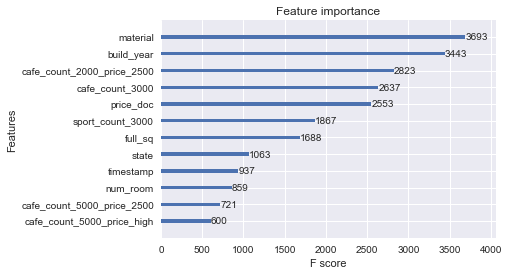

In [33]:
xgb.plot_importance(sub_model)

In [34]:
full_model = xgb.train(xgb_params,
                       dtrain, 
                       num_boost_round=sub_model.best_iteration,
                       verbose_eval=20)

In [35]:
log_y_pred = full_model.predict(dtest)
y_pred = np.exp(log_y_pred) - 1

In [37]:
submit = pd.DataFrame({'id': np.array(test.index), 'price_doc': y_pred})
submit.to_csv('top_feat_submission.csv', index=False)

[ 5050281.   8709003.   5252433.  ...,  4693711.5  5185169.5  8186213. ]
